# Calculating LF/HF

,measured,marker
0,0.000,
1,0.000,
2,0.000,
3,0.000,
4,0.000,
...,...,...
1809995,-0.028,
1809996,-0.027,
1809997,-0.027,
1809998,-0.027,


RR_interval_times is [  0.      0.783   1.59    2.408   3.217   4.008   4.82    5.629   6.434
   7.214   7.991   8.77    9.562  10.37   11.155  11.939  12.74   13.543
  14.329  15.072  15.841  16.622  17.423  18.182  18.97   19.783  20.593
  21.384  22.13   22.898  23.658  24.397  25.124  25.866  26.639  27.423
  28.186  28.936  29.702  30.487  31.236  31.964  32.712  33.509  34.332
  35.141  35.917  36.7    37.518  38.336  39.132  39.916  40.706  41.494
  42.27   43.017  43.778  44.566  45.384  46.178  46.97   47.77   48.582
  49.402  50.223  51.008  51.772  52.525  53.295  54.061  54.819  55.622
  56.434  57.252  58.062  58.876  59.702  60.54   61.357  62.163  62.979
  63.792  64.596  65.391  66.203  67.032  67.865  68.686  69.519  70.362
  71.218  72.049  72.87   73.704  74.547  75.374  76.19   77.021  77.858
  78.682  79.485  80.295  81.119  81.95   82.774  83.62   84.478  85.327
  86.159  87.001  87.844  88.677  89.485  90.307  91.134  91.968  92.783
  93.606  94.442  95.282  96.1

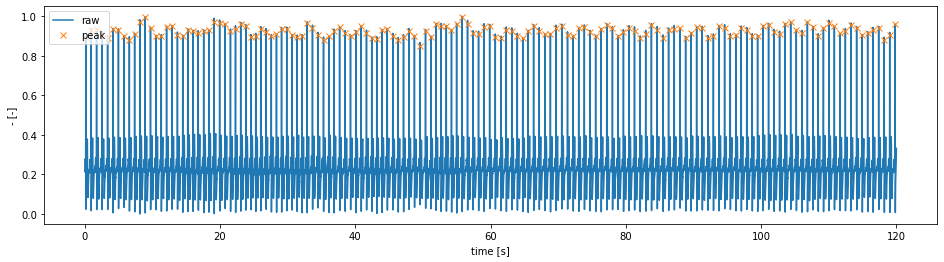

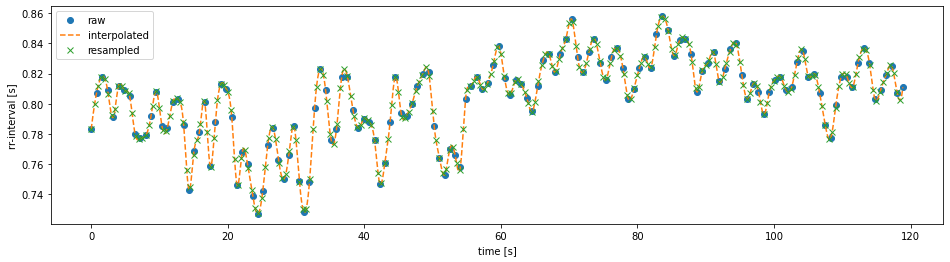

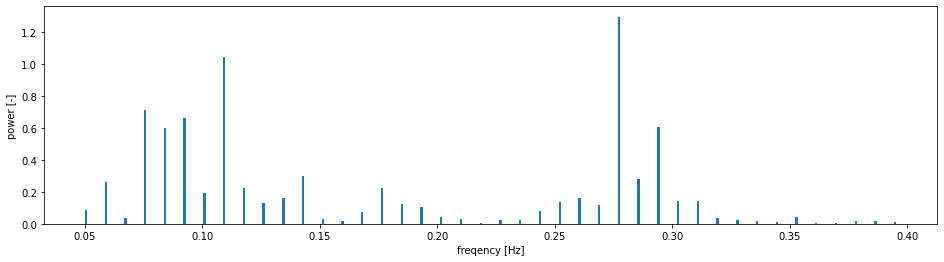

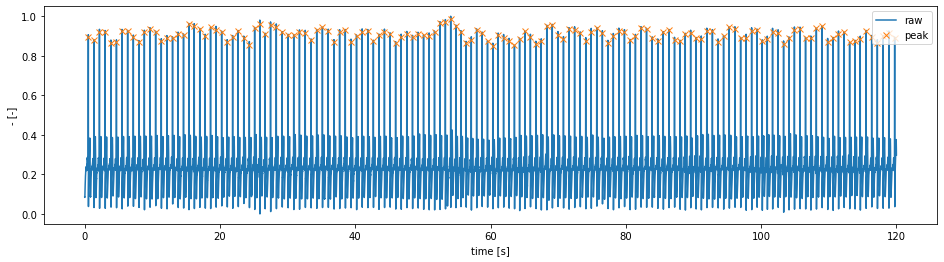

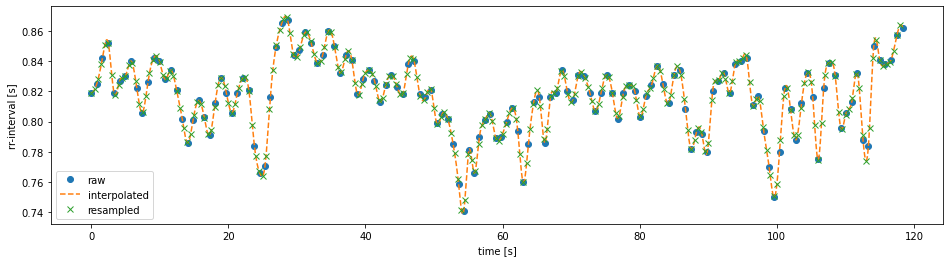

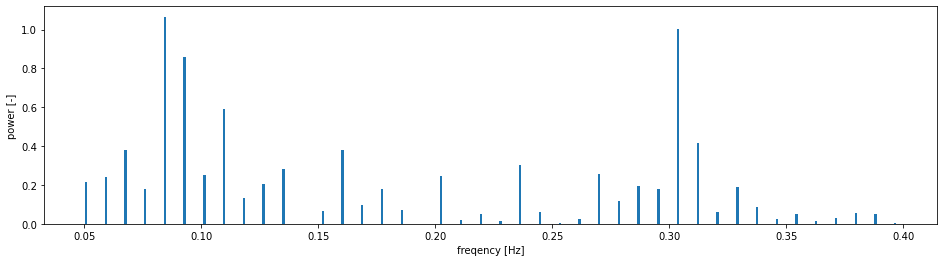

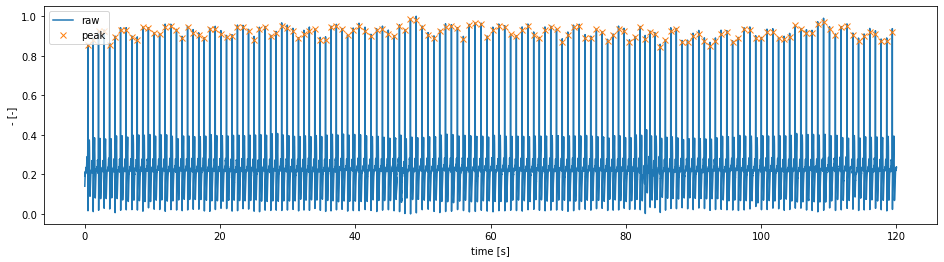

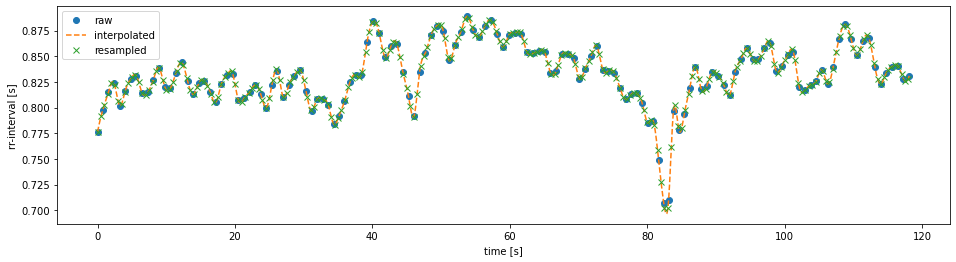

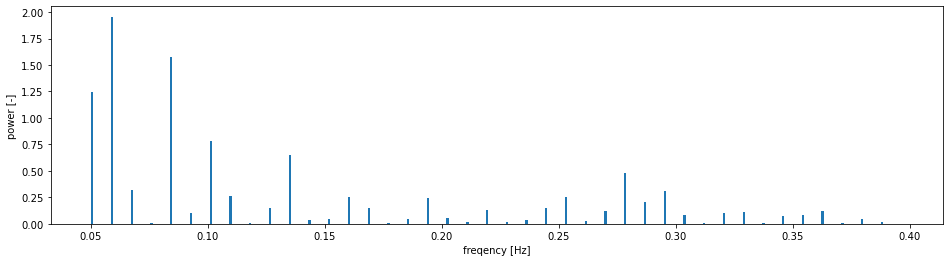

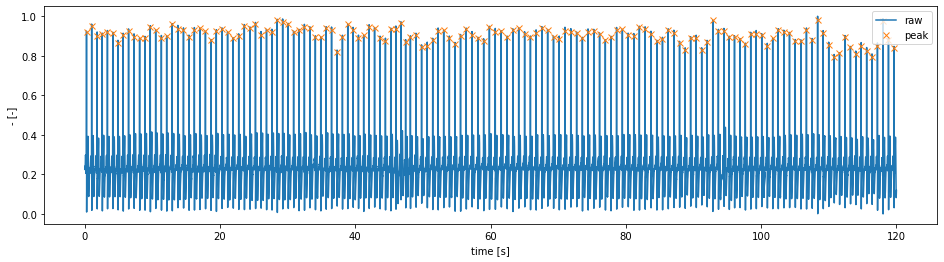

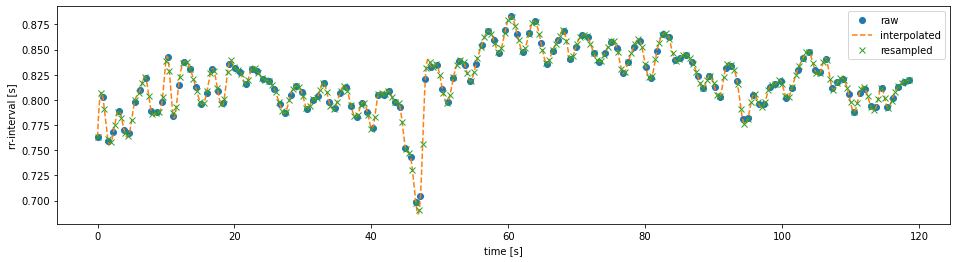

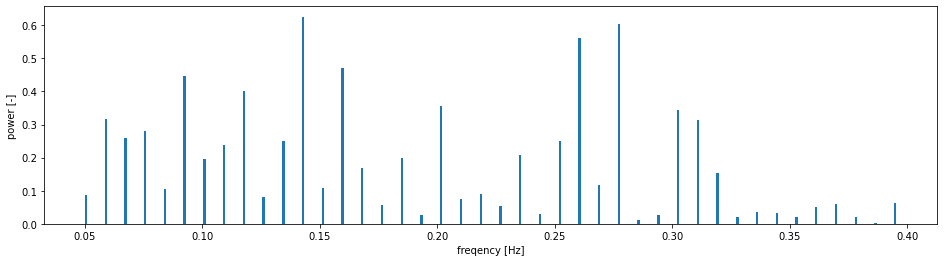

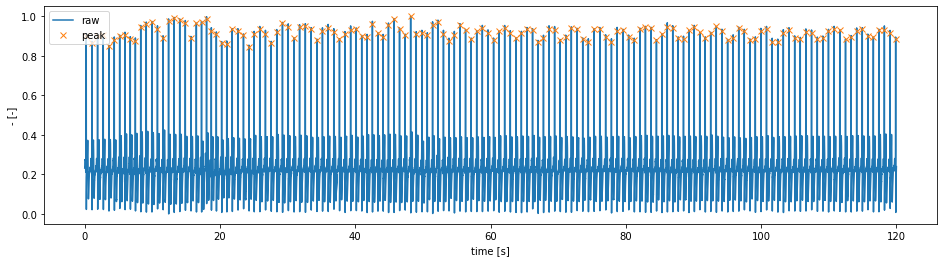

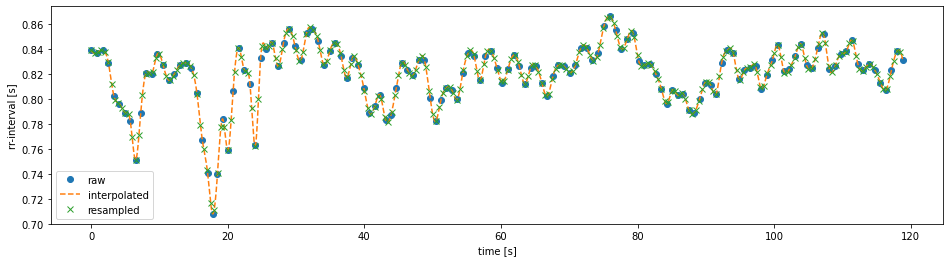

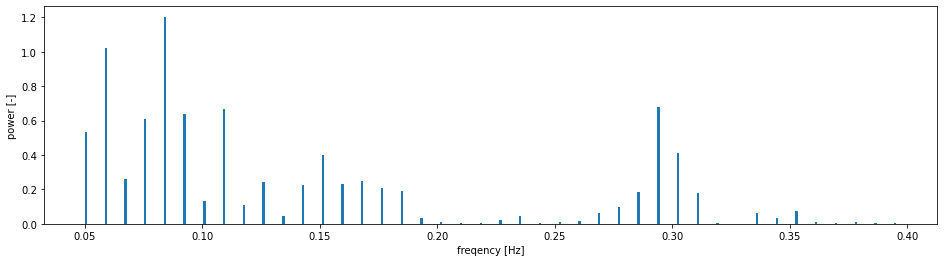

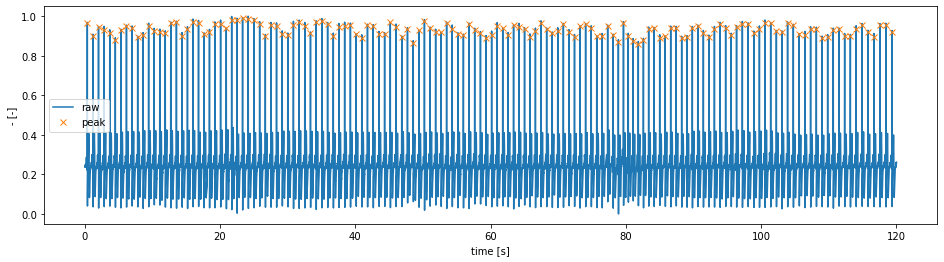

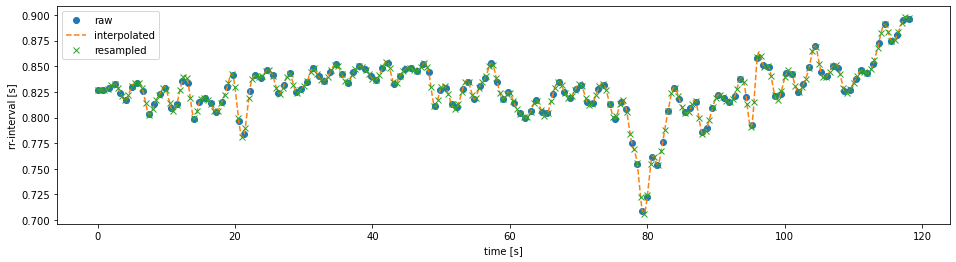

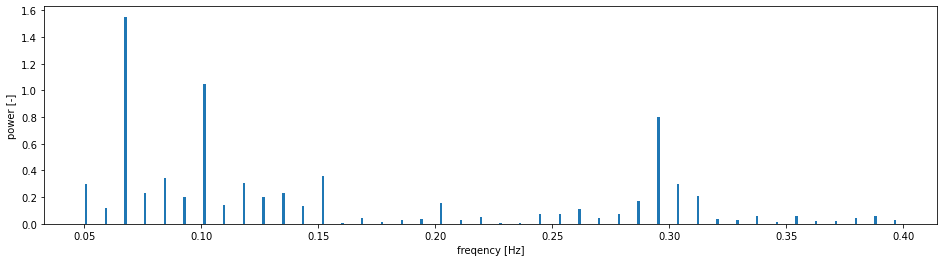

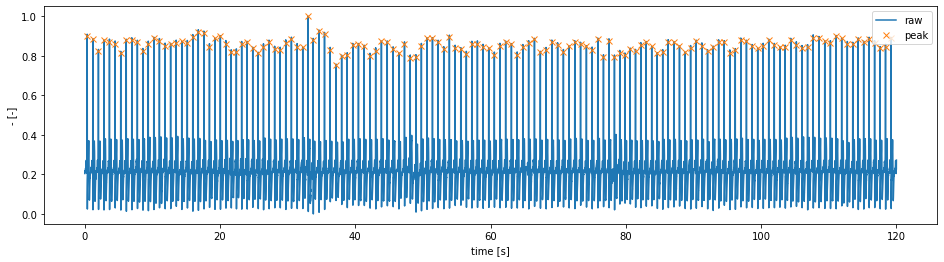

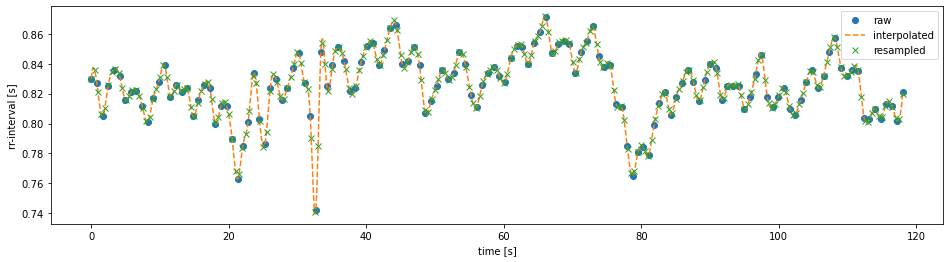

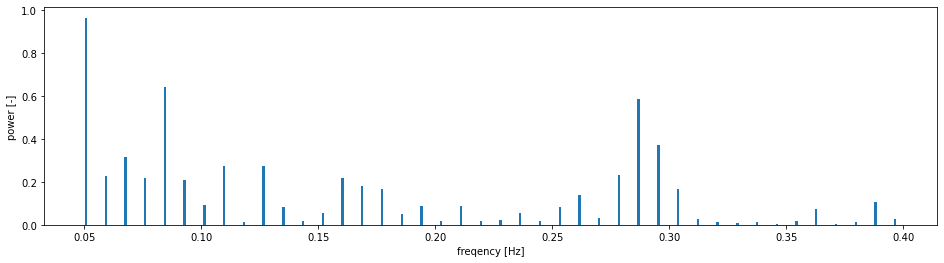

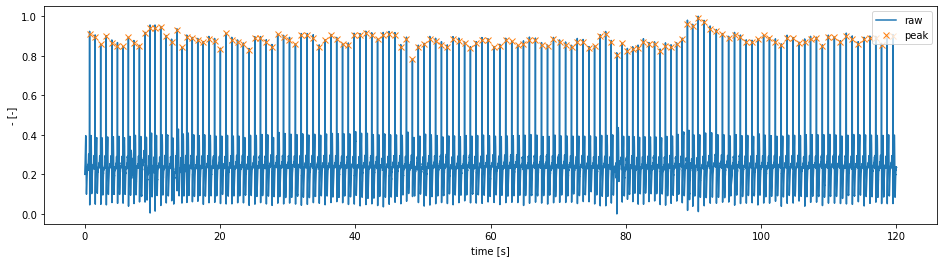

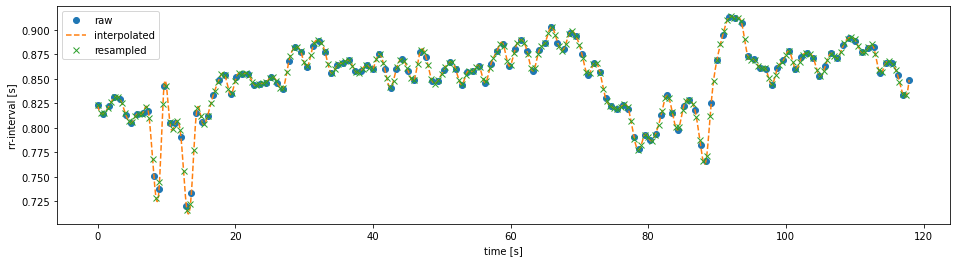

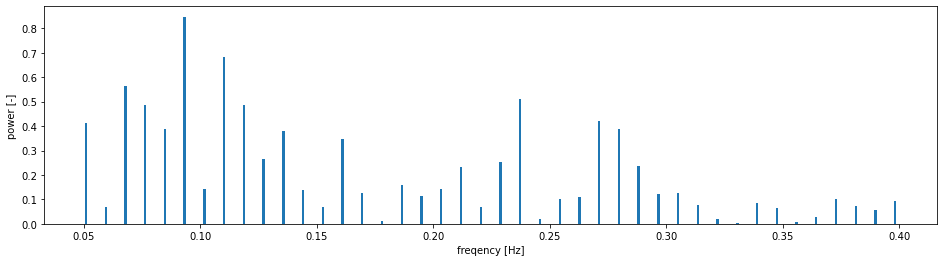

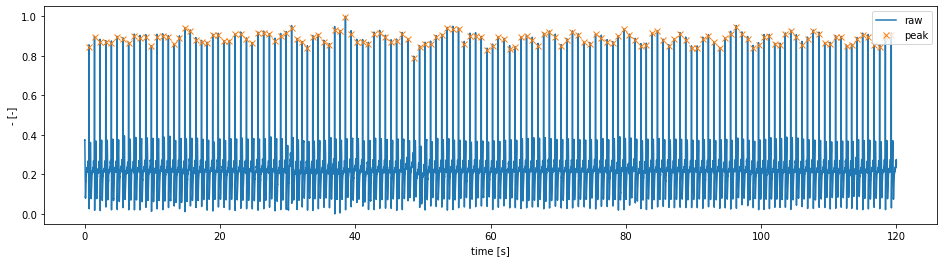

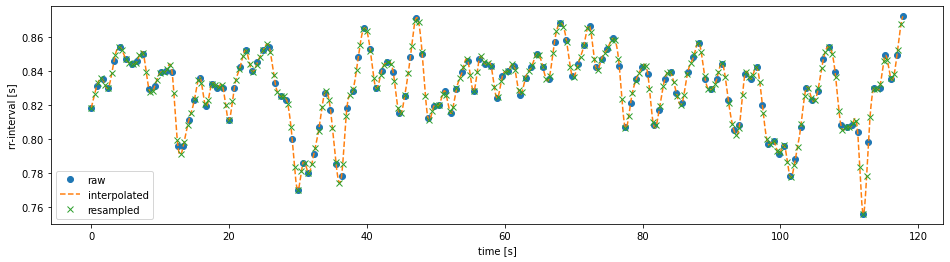

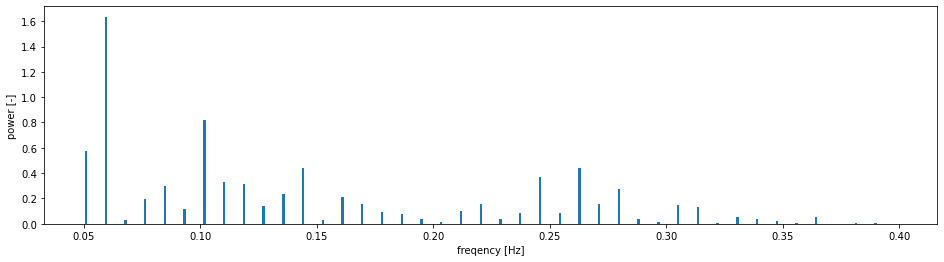

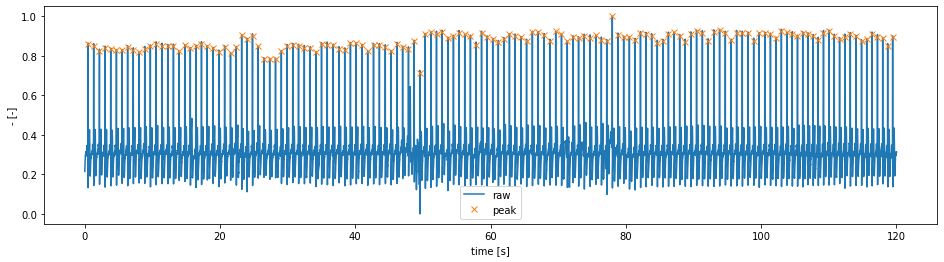

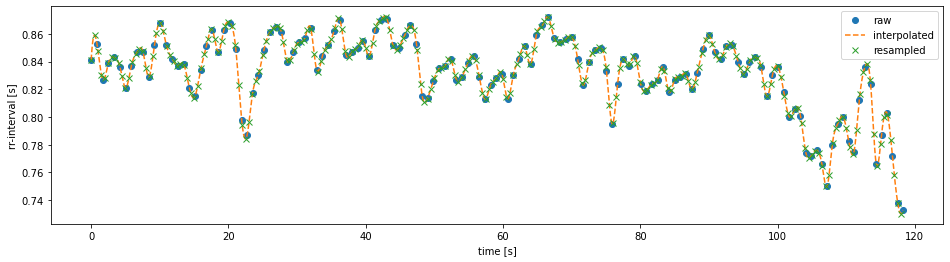

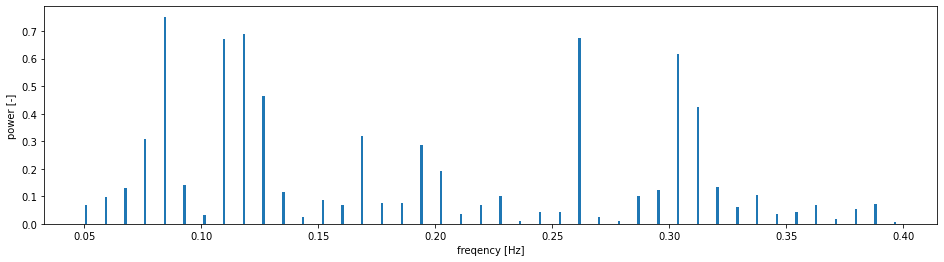

,0
0,1.100892
1,1.019640
2,2.048456
3,0.654870
4,1.752010
5,1.674351
6,0.967489
7,1.111348
8,1.647517
9,0.881190


In [5]:
import glob
import codecs
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import signal
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

class EcgAnalyzer():
    def __init__(self):
        self.lfhf_configuration = {
            'minimum_frequency': 0.05,
            'boundary_frequency': 0.15,
            'maximum_frequency': 0.4,
        }
        self.equipment_configurations = {
            'nexus': {
                'tab_char': '\t',
                'measurement_frequency': 128, # [sec.]
                'data_start_row_index': 14,
                'column_labels_row_index': 11,
            },
            'nihonkoden': {
                'tab_char': '\t',
                'indentation_char': '\r\n',
                'measurement_period': 0.001, # [sec.]
                'data_start_row_index': 13
            }
        }
        
    def get_peak_index_list(self, samples, measurement_frequency, minimum_peak_value_threshold = 0.6, minimum_peak_period_threshold = 0.6):
        # initialize variables
        peak_index_list = []
        preceding_sample = 0
        preceding_difference = 0
        preceding_peak_index = 0
        for index, sample in enumerate(samples):
            difference = sample-preceding_sample
            if index-preceding_peak_index > measurement_frequency*minimum_peak_period_threshold or len(peak_index_list) == 0:
                if sample>minimum_peak_value_threshold:
                    if preceding_difference*difference <= 0:
                        peak_index_list.append(index)
                        preceding_peak_index = index
            preceding_sample = sample
            preceding_difference = difference
        return peak_index_list

    def get_splitted_samples(self, samples, measurement_period, preceding_rest_duration, task_duration, following_rest_duration):
        # calculate number of samples for each phase
        num_preceding_rest_samples = int(preceding_rest_duration/measurement_period)
        num_task_samples = int(task_duration/measurement_period)
        num_following_rest_samples = int(following_rest_duration/measurement_period)
        num_trial_samples = num_preceding_rest_samples+num_task_samples+num_following_rest_samples
        # split samples into preceding-rest and task and following-rest
        preceding_rest_samples = samples[:num_preceding_rest_samples]
        task_samples = samples[num_preceding_rest_samples:num_preceding_rest_samples+num_task_samples]
        following_rest_samples = samples[num_preceding_rest_samples+num_task_samples:num_preceding_rest_samples+num_task_samples+num_following_rest_samples]
        return preceding_rest_samples, task_samples, following_rest_samples

    def get_rr_intervals(self, samples, peak_index_list, measurement_period):
        times = []
        rr_intervals = []
        for i in range(len(peak_index_list))[:-1]:
            current_peak_index = peak_index_list[i]
            next_peak_index = peak_index_list[i+1]
            time = measurement_period*(current_peak_index-peak_index_list[0])
            rr_interval = measurement_period*(next_peak_index-current_peak_index)
            times.append(time)
            rr_intervals.append(rr_interval)
        return np.array(times), np.array(rr_intervals)
   
    def normalize_samples(self, samples):
        minimum_sample = np.min(samples)
        maxinimum_sample = np.max(samples)
        normalized_samples = (samples-minimum_sample)/(maxinimum_sample-minimum_sample)
        return normalized_samples
    
    def get_lfhf(self, samples, measurement_period, resampling_period=0.5, interpolation_method='spline', show_figures=True):
        # calculate LF/HF ratio 
        # interpolate task samples
        samples = self.normalize_samples(samples)
        times = np.arange(samples.shape[0])*measurement_period
        interpolated_samples = interp1d(
            times, 
            samples, 
            kind='cubic'
        )
        samples = interpolated_samples(times)
        # get index of peak point
        peak_index_list = self.get_peak_index_list(samples, 1/measurement_period)
        # get rr-intervals
        # you need interpolated rr-interval at following process (fast fourier transform: fft)
        # to interpolate, you need to kno  w set of time and rr-interval
        rr_interval_times, rr_intervals = self.get_rr_intervals(samples, peak_index_list, measurement_period)
#         rr_intervals = np.array(rr_intervals)/1000
        # interpolate rr-intervals,
        # you can add another interpolation method here
        print("RR_interval_times is {}".format(rr_interval_times))
        print("RR_interval_times_shape is {}".format(rr_interval_times.shape))
        print("RR_intervals is {}".format(rr_intervals))
        print("RR_intervals_shape is {}".format(rr_intervals.shape))
        if interpolation_method=='spline':
            interpolated_rr_intervals = interp1d(rr_interval_times, rr_intervals, kind='cubic')
        elif interpolation_method=='linear':
            interpolated_rr_intervals = interp1d(rr_interval_times, rr_intervals)
        print(interpolated_rr_intervals.x)
        print(interpolated_rr_intervals.y)
        # fft conversion
        start_time = interpolated_rr_intervals.x[0]
        end_time = interpolated_rr_intervals.x[-1]
        fixed_times = np.arange(start_time, end_time, resampling_period)
        num_samples = fixed_times.shape[0]
        resampled_rr_intervals = interpolated_rr_intervals(fixed_times)
        frequencies = np.fft.fftfreq(num_samples, d=resampling_period)
        non_negative_frequency_index = frequencies >= 0

        frequencies = frequencies[non_negative_frequency_index]
        fft_converted = np.fft.fft(resampled_rr_intervals)[non_negative_frequency_index]
        amplitudes = np.abs(fft_converted)
        # real_fft_converted = fft_converted.real
        # imaginary_fft_converted = fft_converted.imag
        # powers = np.sqrt(real_fft_converted**2+imaginary_fft_converted**2)

        powers = amplitudes**2

        interpolated_powers = interp1d(frequencies, powers)

        lfhf_configuration = self.lfhf_configuration
        minimum_frequency = lfhf_configuration['minimum_frequency']
        boundary_frequency = lfhf_configuration['boundary_frequency']
        maximum_frequency = lfhf_configuration['maximum_frequency']

        start_index = np.where(frequencies>=minimum_frequency)[0][0]
        boundary_index = np.where(frequencies>=boundary_frequency)[0][0]
        end_index = np.where(frequencies <= maximum_frequency)[0][-1]

        low_frequency_component_powers = powers[start_index:boundary_index]
        high_frequency_component_powers = powers[boundary_index:end_index+1]
        #利用积分来代替个数
        lf_integrated = integrate.simps(powers[start_index:boundary_index], frequencies[start_index:boundary_index])
        hf_integrated = integrate.simps(powers[boundary_index:end_index+1], frequencies[boundary_index:end_index+1])
        lf_hf_ratio = lf_integrated/hf_integrated

        # print('times shape -> {}'.format(times.shape))
        # print('times       -> {}'.format(times))
        # print('rr_intervals shape -> {}'.format(rr_intervals.shape))
        # print('rr_intervals       -> {}'.format(rr_intervals))
        # print('fixed_times shape -> {}'.format(fixed_times.shape))
        # print('fixed_times       -> {}'.format(fixed_times))
        # print('resampled_rr_intervals shape -> {}'.format(resampled_rr_intervals.shape))
        # print('resampled_rr_intervals       -> {}'.format(resampled_rr_intervals))
        # print('frequencies shape -> {}'.format(frequencies.shape))
        # print('frequencies       -> {}'.format(frequencies[:15]))
        # print('non_negative_frequency_index shape -> {}'.format(non_negative_frequency_index.shape))
        # print('non_negative_frequency_index       -> {}'.format(non_negative_frequency_index))
        # print('real_fft_converted shape-> {}'.format(real_fft_converted.shape))
        # print('real_fft_converted      -> {}'.format(real_fft_converted))
        # print('imaginary_fft_converted =>       {}'.format(imaginary_fft_converted))
        # print('imaginary_fft_converted shape => {}'.format(imaginary_fft_converted.shape))
        # print('amplitudes shape -> {}'.format(amplitudes.shape))
        # print('amplitudes       -> {}'.format(amplitudes))
        # print('power shape -> {}'.format(powers.shape))
        # print('power       -> {}'.format(powers))
        # print('start_index -> {}'.format(start_index))
        # print('boundary_index -> {}'.format(boundary_index))
        # print('end_index -> {}'.format(end_index))
        # print('low_frequency_component_powers -> {}'.format(low_frequency_component_powers))
        # print('high_frequency_component_powers -> {}'.format(high_frequency_component_powers))
        # print('lf_integrated -> {}'.format(lf_integrated))
        # print('hf_integrated -> {}'.format(hf_integrated))
        # print('lf_hf_ratio -> {}'.format(lf_hf_ratio))
        if show_figures:
            fig, ax = plt.subplots(figsize=(16,4))
            ax.plot(
                times, 
                samples, 
                '-', 
                times[peak_index_list], 
                samples[peak_index_list], 
                'x'
            )
            ax.legend(['raw', 'peak'], loc='best')
            ax.set_xlabel("time [s]")
            ax.set_ylabel("- [-]")
            plt.show()
            fig, ax = plt.subplots(figsize=(16,4))
            ax.plot(
                rr_interval_times, 
                rr_intervals, 
                'o', 
                np.arange(start_time, end_time,0.001), 
                interpolated_rr_intervals(np.arange(start_time, end_time,0.001)), 
                '--', 
                fixed_times, 
                resampled_rr_intervals, 
                'x'
            )
            ax.legend(['raw', 'interpolated', 'resampled'], loc='best')
            ax.set_xlabel("time [s]")
            ax.set_ylabel("rr-interval [s]")
            plt.show()
            fig, ax = plt.subplots(figsize=(16,4))
#             ax.plot(
#                 frequencies[start_index: end_index+1],
#                 powers[start_index: end_index+1], 
#                 'o', 
#                 np.arange(frequencies[start_index], frequencies[end_index+1],0.001), 
#                 interpolated_powers(np.arange(frequencies[start_index], frequencies[end_index+1],0.001)), 
#                 '--'
#             )
            ax.bar(
                frequencies[start_index: end_index+1],
                powers[start_index: end_index+1], 
                0.001 
            )
            ax.set_xlabel("freqency [Hz]")
            ax.set_ylabel("power [-]")
            plt.show()
        return lf_hf_ratio

    def analyze_nihonkoden_data(self, ecg_filepath, interpolation_method='spline', preceding_rest_duration=45, task_duration=30, following_rest_duration=45):
        # define constants
        equipment_name = 'nihonkoden'
        equipment_configuration = self.equipment_configurations[equipment_name]
        tab_char = equipment_configuration['tab_char']
        indentation_char = equipment_configuration['indentation_char']
        data_start_row_index = equipment_configuration['data_start_row_index']
        measurement_period = equipment_configuration['measurement_period']
        measurement_frequency = 1/measurement_period # [Hz]
        # load ecg data
        ecg_file = codecs.open(ecg_filepath, 'r', 'utf-8', 'ignore')
        text_lines = [text_line.split(tab_char) for text_line in ecg_file.read().split(indentation_char)]
        ecg_data_marker_rows = [[float(text_line[0]), text_line[1]] for text_line in text_lines[data_start_row_index : -1]]
        column_labels = ['measured', 'marker']
        # create dataframe of ecg data so that you can manipulate those data easily
        ecg_dataframe = pd.DataFrame(ecg_data_marker_rows, columns=column_labels)
        display(ecg_dataframe)
        # get indexes of starting time
        query_statement = '{} != ""'.format(column_labels[1])
        marker_index_list = ecg_dataframe.query(query_statement).index
        # get list of trial data
        all_samples = ecg_dataframe[column_labels[0]].values
        # calculate LF/HF ratio per trial
        lf_hf_ratios = []
        for marker_index in marker_index_list: 
            samples = all_samples[marker_index:]
            # split samples into preceding-rest and task and following-rest
            _, task_samples, _ = self.get_splitted_samples(
                samples, 
                measurement_period, 
                preceding_rest_duration, 
                task_duration, 
                following_rest_duration
            )
            # calculate LF/HF ratio 
            lf_hf_ratio = self.get_lfhf(
                task_samples, 
                measurement_period,
                interpolation_method=interpolation_method
            )
            lf_hf_ratios.append(lf_hf_ratio)
        display(pd.DataFrame(lf_hf_ratios))

    def analyze_nexus_data(self, ecg_filepath, interpolation_method='spline', preceding_rest_duration=45, task_duration=30, following_rest_duration=45):
        equipment_name = 'nexus'
        equipment_configuration = self.equipment_configurations[equipment_name]
        tab_char = equipment_configuration['tab_char']
        column_labels_row_index = equipment_configuration['column_labels_row_index']
        data_start_row_index = equipment_configuration['data_start_row_index']
        measurement_frequency = equipment_configuration['measurement_frequency'] # [Hz]
        measurement_period = 1/measurement_frequency # [s]
        ecg_file = open(ecg_filepath)
        text_lines = [text_line.split(tab_char) for text_line in ecg_file.readlines()]
        ecg_data_rows = [[text_line[0], float(text_line[1]), float(text_line[2])] for text_line in text_lines[data_start_row_index : -2]]
        column_labels = text_lines[column_labels_row_index][:3]
        ecg_dataframe = pd.DataFrame(ecg_data_rows, columns=column_labels)
        display(ecg_dataframe)
        samples = ecg_dataframe[column_labels[1]].values
        # split samples into preceding-rest and task and following-rest
        _, task_samples, _ = self.get_splitted_samples(
            samples, 
            measurement_period, 
            preceding_rest_duration, 
            task_duration, 
            following_rest_duration
        )
        # calculate LF/HF ratio 
        lf_hf_ratio = self.get_lfhf(
            task_samples,
            measurement_period,
            interpolation_method=interpolation_method
        )
        print('LF/HF -> {}\n\n'.format(lf_hf_ratio))
ecg_analyzer = EcgAnalyzer()
ecg_filepath = './nihonkoden-ecg/20200713.txt'
ecg_analyzer.analyze_nihonkoden_data(
    ecg_filepath,
    interpolation_method='spline',
    preceding_rest_duration=0,
    task_duration=120,
    following_rest_duration=0
)

## Nihonkoden

NameError: name 'EcgAnalyzer' is not defined

## NeXus

,TIME,Sensor-G:BVP,HR (BVP)
0,00:00:00,-0.904,70.000
1,00:00:00,-1.124,70.000
2,00:00:00,-0.927,70.000
3,00:00:00,-0.815,70.000
4,00:00:00,-0.872,70.000
...,...,...,...
15355,00:01:59,0.326,71.116
15356,00:01:59,0.232,71.116
15357,00:01:59,0.003,71.116
15358,00:01:59,0.340,71.116


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (36,)
rr_intervals       -> [0.8359375 0.84375   0.8203125 0.796875  0.8046875 0.8203125 0.8203125
 0.78125   0.8203125 0.8203125 0.8203125 0.8203125 0.8203125 0.8125
 0.859375  0.796875  0.84375   0.8203125 0.859375  0.8359375 0.8046875
 0.8359375 0.84375   0.8203125 0.859375  0.8203125 0.8203125 0.859375
 0.84375   0.8203125 0.8515625 0.828125  0.8203125 0.78125   0.7734375
 0.78125  ]
fixed_times shape -> (29,)
fixed_times       -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
resampled_rr_intervals shape -> (29,)
resampled_rr_intervals       -> [0.8359375  0.84086468 0.80878782 0.79932341 0.81828281 0.81663236
 0.78932139 0.82486883 0.81988766 0.82038699 0.81533426 0.83989701
 0.81408978 0.83987503 0.82089373 0.86143604 0.81529867 0.82362871
 0.84605059 0.

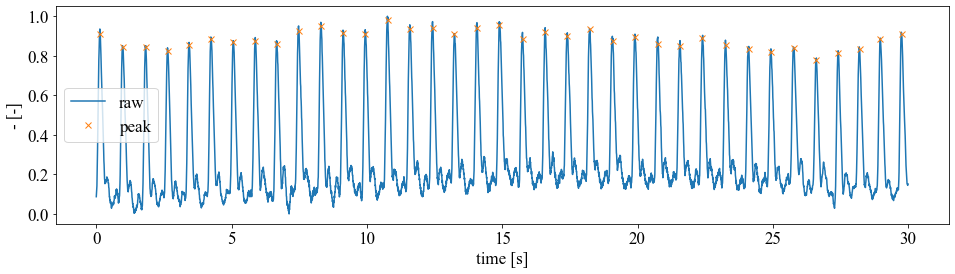

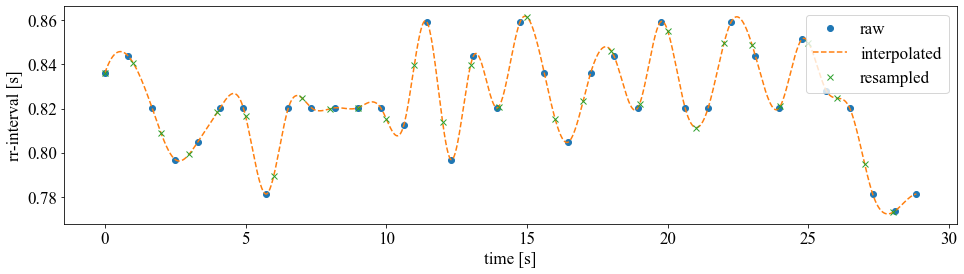

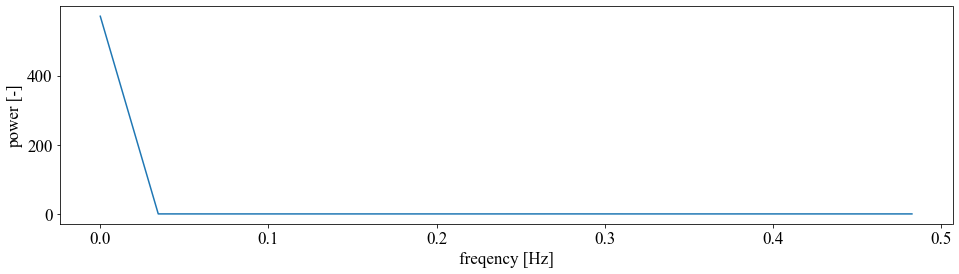

LF/HF -> 0.17302211163624834




,TIME,Sensor-G:BVP,HR (BVP)
0,00:00:00,14.860,70.000
1,00:00:00,14.575,70.000
2,00:00:00,14.346,70.000
3,00:00:00,13.788,70.000
4,00:00:00,12.819,70.000
...,...,...,...
15355,00:01:59,11.005,71.116
15356,00:01:59,10.586,71.116
15357,00:01:59,9.708,71.116
15358,00:01:59,9.127,71.116


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (37,)
rr_intervals       -> [0.8828125 0.84375   0.796875  0.7578125 0.7734375 0.765625  0.8046875
 0.7578125 0.7578125 0.78125   0.8203125 0.8203125 0.84375   0.7734375
 0.765625  0.796875  0.78125   0.796875  0.78125   0.78125   0.8203125
 0.796875  0.8046875 0.7578125 0.7578125 0.7734375 0.7890625 0.78125
 0.71875   0.7578125 0.78125   0.78125   0.7734375 0.796875  0.8046875
 0.8203125 0.796875 ]
fixed_times shape -> (29,)
fixed_times       -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
resampled_rr_intervals shape -> (29,)
resampled_rr_intervals       -> [0.8828125  0.83805833 0.77877482 0.76809144 0.76431076 0.80029878
 0.75103602 0.77497178 0.82142866 0.83022922 0.8115313  0.76028901
 0.79704156 0.78437457 0.79053762 0.77770961 0.819952   0.79974278
 0

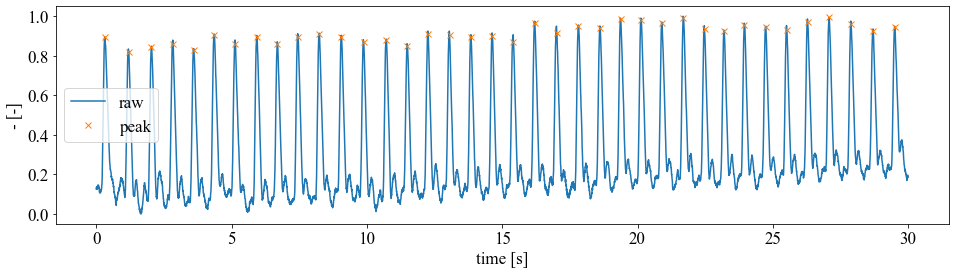

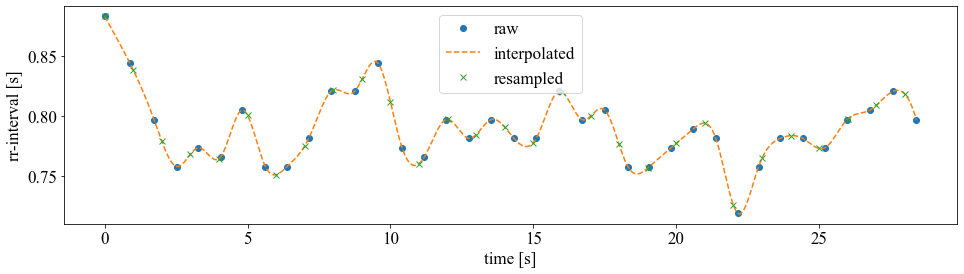

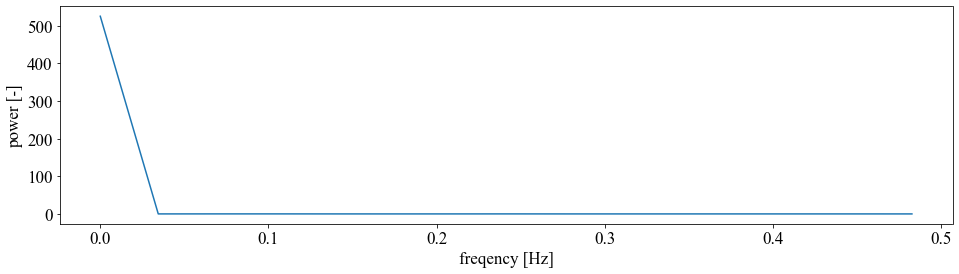

LF/HF -> 1.459196750883882




,TIME,Sensor-E:SC/GSR,Sensor-G:BVP
0,00:00:00,1.353,14.824
1,00:00:00,1.353,13.651
2,00:00:00,1.353,12.686
3,00:00:00,1.353,11.800
4,00:00:00,1.353,10.121
...,...,...,...
120827,00:15:43,1.256,-8.749
120828,00:15:43,1.257,-8.716
120829,00:15:43,1.257,-9.687
120830,00:15:43,1.257,-10.007


error


,TIME,Sensor-G:BVP,HR (BVP)
0,00:00:00,1.577,70.000
1,00:00:00,3.165,70.000
2,00:00:00,4.856,70.000
3,00:00:00,6.412,70.000
4,00:00:00,8.207,70.000
...,...,...,...
15611,00:02:01,-2.435,77.581
15612,00:02:01,-2.279,77.581
15613,00:02:01,-2.281,77.581
15614,00:02:01,-1.971,77.581


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (35,)
rr_intervals       -> [0.8828125 0.8359375 0.84375   0.8359375 0.84375   0.8359375 0.8359375
 0.8671875 0.8359375 0.84375   0.8515625 0.84375   0.84375   0.8359375
 0.84375   0.8515625 0.828125  0.8359375 0.84375   0.8515625 0.828125
 0.8203125 0.8359375 0.8046875 0.796875  0.7578125 0.78125   0.8046875
 0.8125    0.8046875 0.828125  0.8359375 0.8203125 0.7890625 0.84375  ]
fixed_times shape -> (29,)
fixed_times       -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
resampled_rr_intervals shape -> (29,)
resampled_rr_intervals       -> [0.8828125  0.8362625  0.84187784 0.83952209 0.83969556 0.83377212
 0.86651316 0.83341348 0.84991969 0.84641501 0.84415808 0.8359375
 0.8468752  0.84322841 0.8300085  0.84170811 0.85186864 0.82508122
 0.82748559 0.81942513 

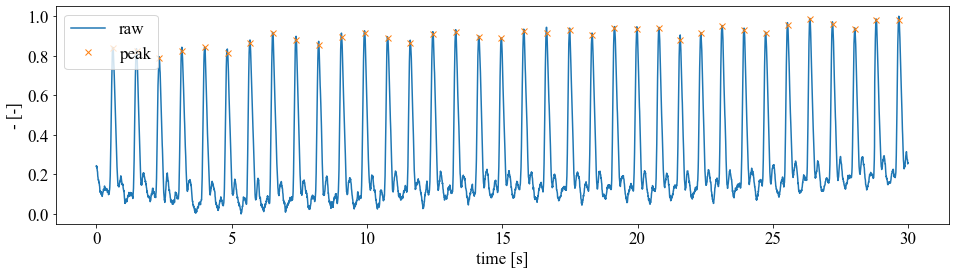

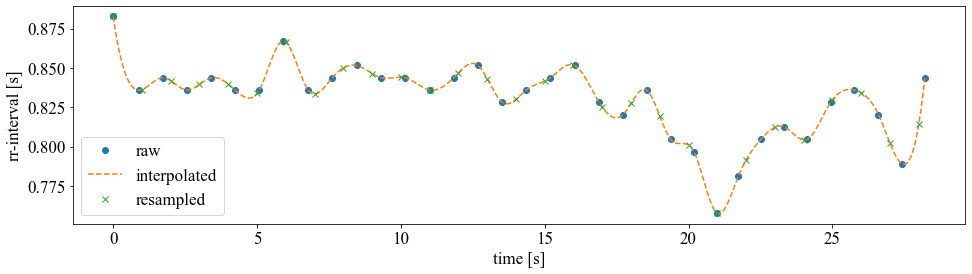

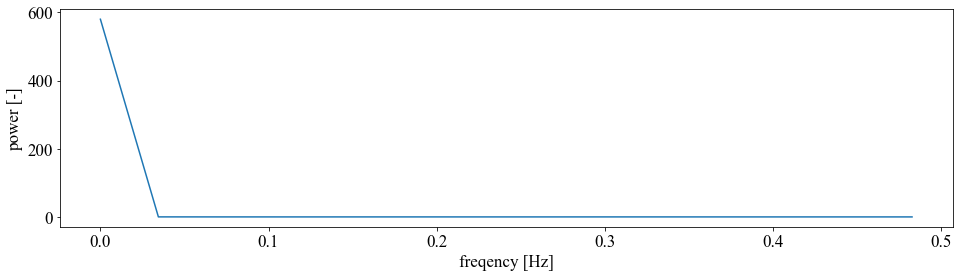

LF/HF -> 0.4451303990475114




,TIME,Sensor-G:BVP,HR (BVP)
0,00:00:00,16.614,70.000
1,00:00:00,17.516,70.000
2,00:00:00,17.766,70.000
3,00:00:00,18.124,70.000
4,00:00:00,17.915,70.000
...,...,...,...
17019,00:02:12,-0.927,70.464
17020,00:02:12,-0.901,70.464
17021,00:02:12,-0.559,70.464
17022,00:02:12,-0.499,70.464


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (35,)
rr_intervals       -> [0.765625  0.796875  0.8046875 0.8359375 0.8203125 0.8203125 0.8203125
 0.8359375 0.8203125 0.8046875 0.8203125 0.8203125 0.8203125 0.8125
 0.828125  0.8359375 0.84375   0.8125    0.8125    0.8359375 0.84375
 0.84375   0.8359375 0.859375  0.859375  0.859375  0.8203125 0.859375
 0.84375   0.8203125 0.8125    0.8203125 0.8359375 0.8203125 0.8046875]
fixed_times shape -> (29,)
fixed_times       -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
resampled_rr_intervals shape -> (29,)
resampled_rr_intervals       -> [0.765625   0.79781223 0.82391607 0.82508127 0.82027715 0.82298807
 0.8334641  0.8070807  0.81813608 0.82027071 0.81755051 0.81931756
 0.83357543 0.84459095 0.81014233 0.82040992 0.84202461 0.84525377
 0.83538394 0.86072254 0.86

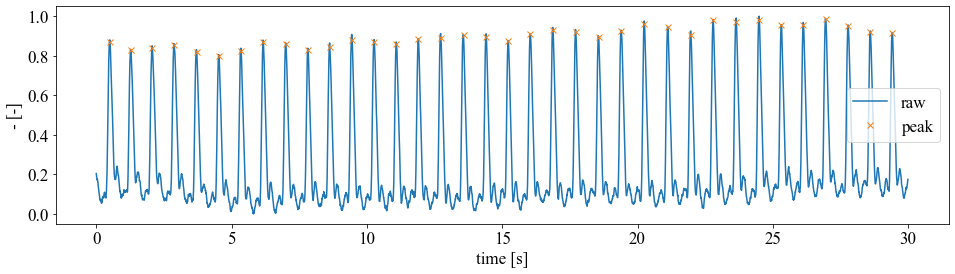

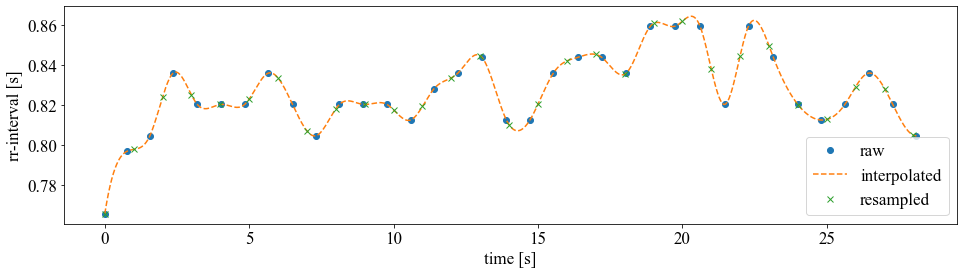

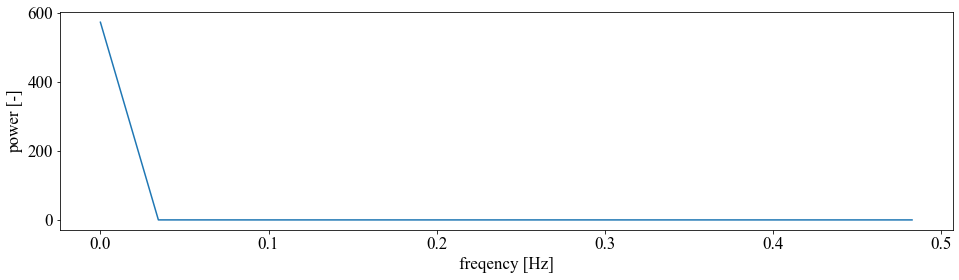

LF/HF -> 0.31208915369614504




,TIME,Sensor-E:SC/GSR,Sensor-G:BVP
0,00:00:00,1.120,0.118
1,00:00:00,1.120,1.677
2,00:00:00,1.120,3.247
3,00:00:00,1.120,5.180
4,00:00:00,1.120,6.134
...,...,...,...
11771,00:01:31,1.195,14.445
11772,00:01:31,1.195,11.606
11773,00:01:31,1.195,9.603
11774,00:01:31,1.195,8.640


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (13,)
rr_intervals       -> [0.6015625 0.6015625 0.6015625 0.6015625 0.6015625 0.609375  0.609375
 0.6015625 0.6015625 0.6015625 0.6015625 0.6015625 0.6015625]
fixed_times shape -> (8,)
fixed_times       -> [0. 1. 2. 3. 4. 5. 6. 7.]
resampled_rr_intervals shape -> (8,)
resampled_rr_intervals       -> [0.6015625  0.60149677 0.60105201 0.60929229 0.60412049 0.6017574
 0.60155733 0.60154472]
frequencies shape -> (4,)
frequencies       -> [0.    0.125 0.25  0.375]
non_negative_frequency_index shape -> (8,)
non_negative_frequency_index       -> [ True  True  True  True False False False False]
amplitudes shape -> (4,)
amplitudes       -> [4.82238352 0.00951373 0.0081821  0.00657813]
power shape -> (4,)
power       -> [2.32553828e+01 9.05110631e-05 6.69468225e-05 4.32717816e-05]
start_index -> 1
boundary_index -> 2
end_index -> 3
low_fre

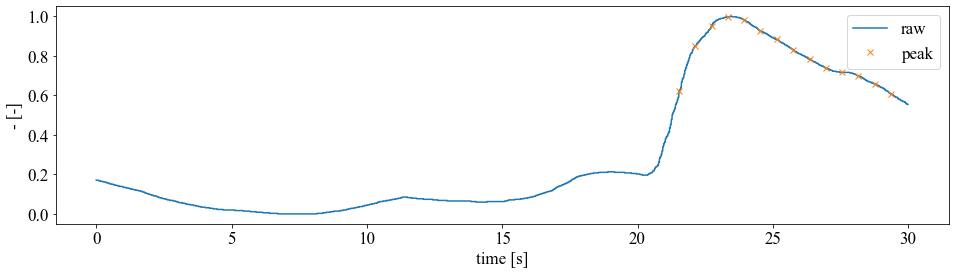

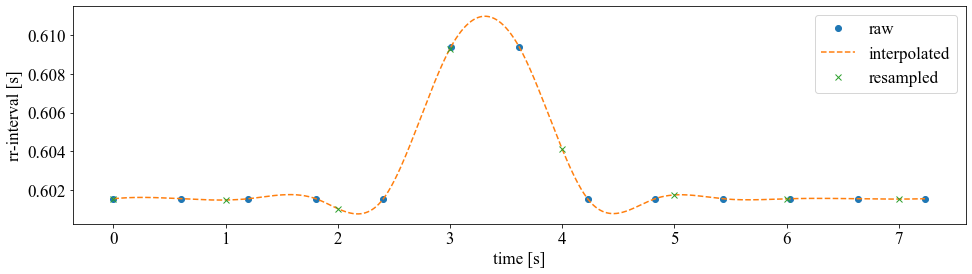

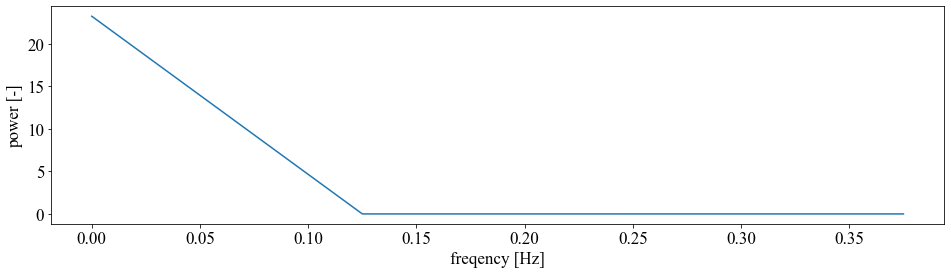

LF/HF -> 0.0




,TIME,Sensor-G:BVP,HR (BVP)
0,00:00:00,-2.758,70.000
1,00:00:00,-3.359,70.000
2,00:00:00,-2.943,70.000
3,00:00:00,-3.250,70.000
4,00:00:00,-3.171,70.000
...,...,...,...
11259,00:01:27,-2.593,71.116
11260,00:01:27,-2.731,71.116
11261,00:01:27,-2.596,71.116
11262,00:01:27,-2.380,71.116


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (36,)
rr_intervals       -> [0.8046875 0.8203125 0.859375  0.84375   0.8359375 0.8203125 0.8203125
 0.84375   0.8359375 0.828125  0.8515625 0.84375   0.859375  0.8203125
 0.859375  0.859375  0.828125  0.828125  0.7890625 0.7578125 0.7578125
 0.78125   0.78125   0.8203125 0.8203125 0.8203125 0.84375   0.8359375
 0.859375  0.84375   0.8359375 0.84375   0.859375  0.859375  0.8046875
 0.8359375]
fixed_times shape -> (29,)
fixed_times       -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
resampled_rr_intervals shape -> (29,)
resampled_rr_intervals       -> [0.8046875  0.83190344 0.8566146  0.83835132 0.82333227 0.82066203
 0.84516491 0.82880106 0.84447233 0.84356106 0.85953778 0.82192103
 0.86776135 0.84039941 0.82969723 0.79254086 0.75505398 0.77145002
 0.7789534

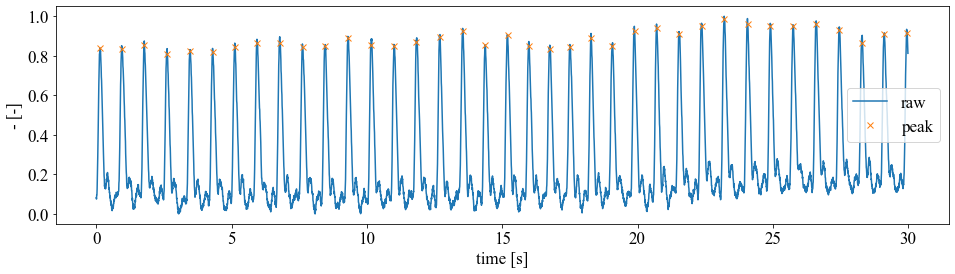

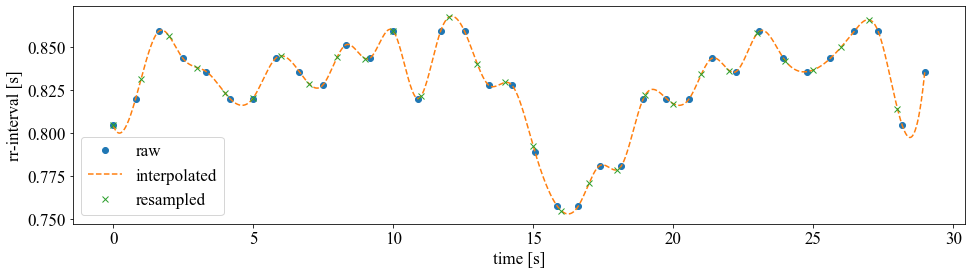

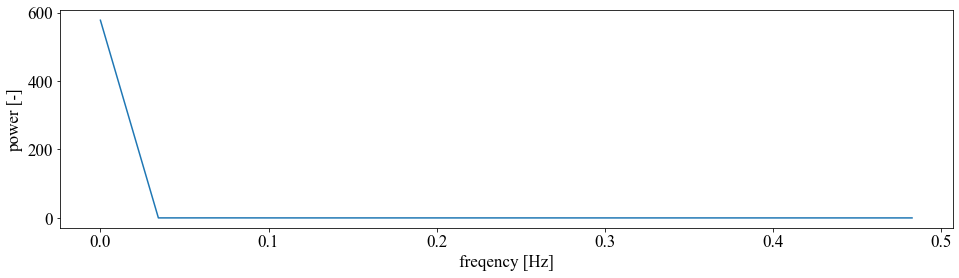

LF/HF -> 1.8868795600401054




,TIME,Sensor-G:BVP,HR (BVP)
0,00:00:00,11.196,70.000
1,00:00:00,10.540,70.000
2,00:00:00,9.773,70.000
3,00:00:00,9.430,70.000
4,00:00:00,8.494,70.000
...,...,...,...
15355,00:01:59,13.769,71.781
15356,00:01:59,13.647,71.781
15357,00:01:59,13.077,71.781
15358,00:01:59,12.440,71.781


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (35,)
rr_intervals       -> [0.859375  0.8203125 0.796875  0.8203125 0.7578125 0.78125   0.8046875
 0.796875  0.78125   0.8046875 0.8046875 0.84375   0.8203125 0.8046875
 0.8203125 0.859375  0.859375  0.6796875 1.        0.859375  0.8359375
 0.8046875 0.796875  0.8828125 0.875     0.8828125 0.890625  0.8671875
 0.859375  0.859375  0.859375  0.859375  0.8203125 0.859375  0.859375 ]
fixed_times shape -> (29,)
fixed_times       -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
resampled_rr_intervals shape -> (29,)
resampled_rr_intervals       -> [0.859375   0.81228054 0.81027658 0.77882189 0.7782734  0.80549651
 0.7862311  0.7992512  0.80407167 0.84450823 0.8097048  0.81247741
 0.85015645 0.85365737 0.73830968 0.99629911 0.82585289 0.81686915
 0.79578842 0.8901381

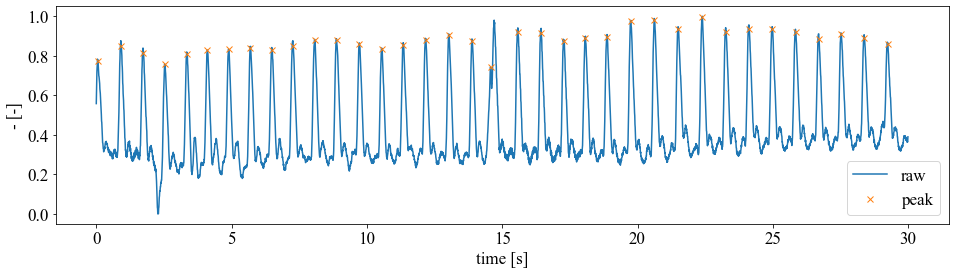

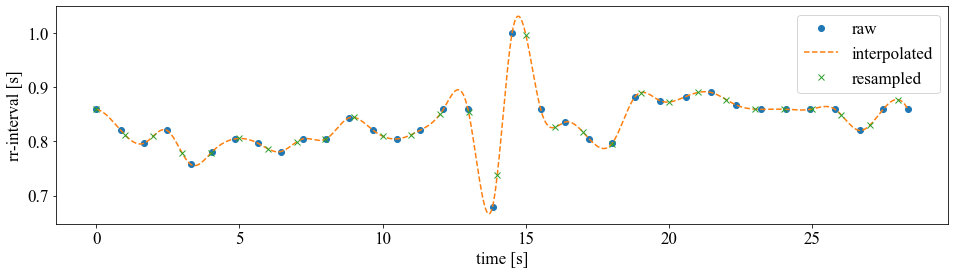

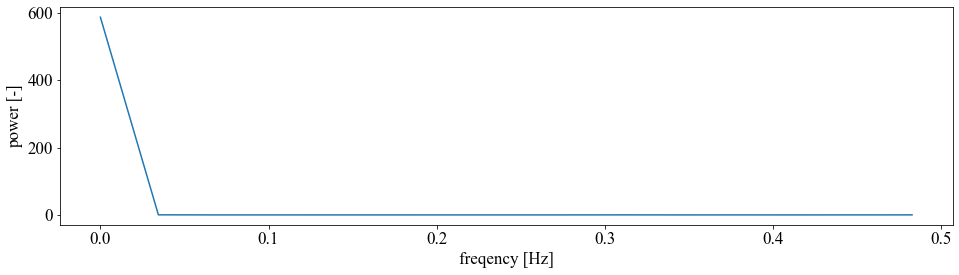

LF/HF -> 0.11383374182801315




,TIME,Sensor-G:BVP,HR (BVP)
0,00:00:00,14.648,70.000
1,00:00:00,14.234,70.000
2,00:00:00,14.056,70.000
3,00:00:00,13.533,70.000
4,00:00:00,12.949,70.000
...,...,...,...
15355,00:01:59,14.941,69.194
15356,00:01:59,14.725,69.194
15357,00:01:59,14.106,69.194
15358,00:01:59,13.607,69.194


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (35,)
rr_intervals       -> [0.8359375 0.8046875 0.8125    0.84375   0.84375   0.859375  0.8359375
 0.8359375 0.859375  0.859375  0.84375   0.8359375 0.8203125 0.8515625
 0.8828125 0.8359375 0.84375   0.8671875 0.84375   0.8046875 0.828125
 0.84375   0.8515625 0.875     0.84375   0.8203125 0.84375   0.8515625
 0.8359375 0.8203125 0.8203125 0.828125  0.8359375 0.8359375 0.84375  ]
fixed_times shape -> (29,)
fixed_times       -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
resampled_rr_intervals shape -> (29,)
resampled_rr_intervals       -> [0.8359375  0.80307057 0.82777864 0.84371455 0.85866043 0.8359375
 0.84017    0.86301879 0.85036646 0.83921121 0.82023741 0.85809716
 0.87288077 0.83178502 0.86202987 0.85233787 0.80482593 0.83388989
 0.84510064 0.86879783 

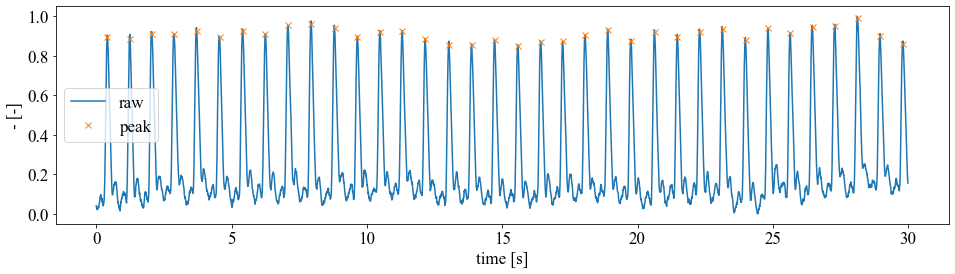

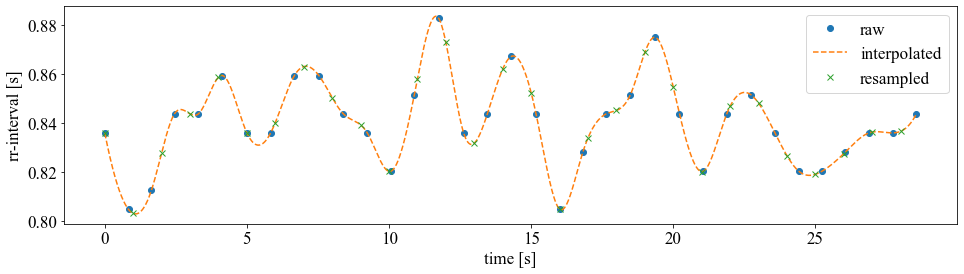

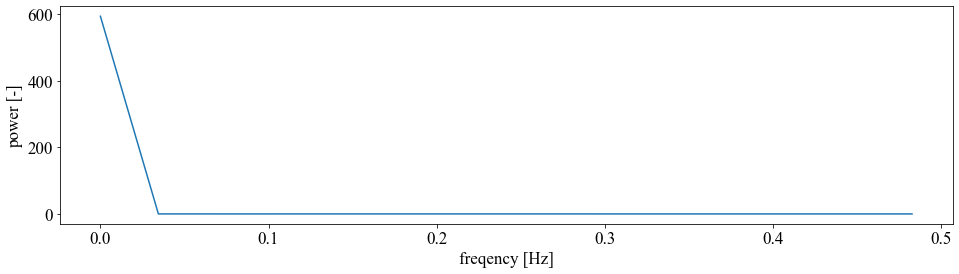

LF/HF -> 0.13619861494601418




,TIME,Sensor-G:BVP,HR (BVP)
0,00:00:00,5.758,70.000
1,00:00:00,5.350,70.000
2,00:00:00,3.962,70.000
3,00:00:00,3.580,70.000
4,00:00:00,2.546,70.000
...,...,...,...
15355,00:01:59,-0.210,70.464
15356,00:01:59,-0.522,70.464
15357,00:01:59,-0.621,70.464
15358,00:01:59,-0.339,70.464


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (37,)
rr_intervals       -> [0.8125    0.828125  0.734375  0.7421875 0.78125   0.8203125 0.8046875
 0.78125   0.796875  0.84375   0.8359375 0.8203125 0.8203125 0.84375
 0.859375  0.78125   0.78125   0.78125   0.796875  0.8046875 0.7734375
 0.78125   0.8203125 0.8203125 0.8046875 0.78125   0.7734375 0.7421875
 0.7421875 0.71875   0.78125   0.7734375 0.78125   0.8046875 0.859375
 0.8359375 0.8203125]
fixed_times shape -> (29,)
fixed_times       -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
resampled_rr_intervals shape -> (29,)
resampled_rr_intervals       -> [0.8125     0.80587531 0.72842376 0.77433908 0.82149627 0.7942469
 0.78473365 0.83986054 0.83453686 0.81850101 0.82844347 0.86461348
 0.79006234 0.78212324 0.78535069 0.8067723  0.77555719 0.78894414
 0.8

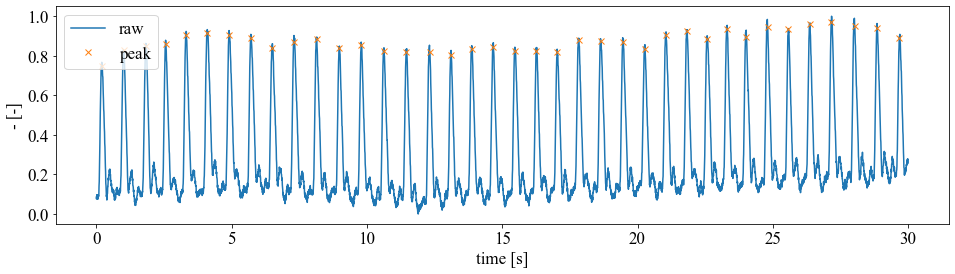

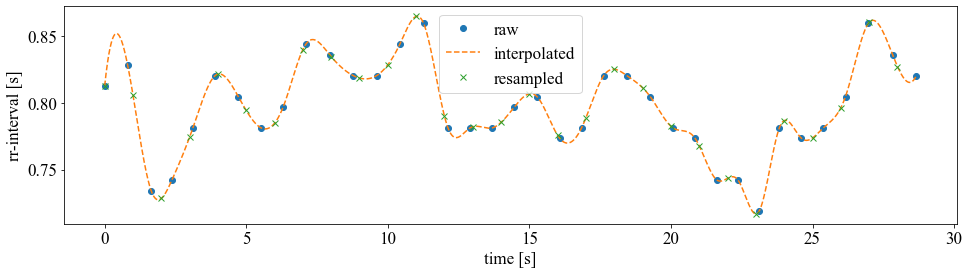

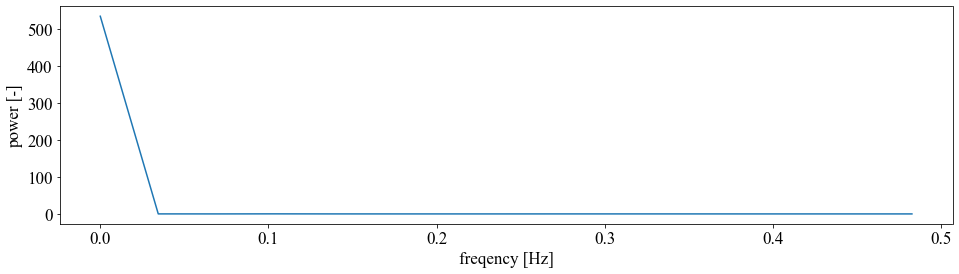

LF/HF -> 1.767774529883055




,TIME,Sensor-G:BVP,HR (BVP)
0,00:00:00,3.488,70.000
1,00:00:00,2.463,70.000
2,00:00:00,1.325,70.000
3,00:00:00,0.618,70.000
4,00:00:00,-0.427,70.000
...,...,...,...
15227,00:01:58,-1.712,71.781
15228,00:01:58,-2.379,71.781
15229,00:01:58,-2.395,71.781
15230,00:01:58,-2.723,71.781


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (36,)
rr_intervals       -> [0.8203125 0.796875  0.78125   0.7265625 0.734375  0.78125   0.78125
 0.78125   0.8125    0.828125  0.8359375 0.8203125 0.828125  0.8359375
 0.8203125 0.8046875 0.8125    0.8203125 0.8046875 0.8046875 0.8125
 0.84375   0.8359375 0.828125  0.8203125 0.8359375 0.859375  0.84375
 0.8359375 0.8671875 0.8359375 0.8203125 0.78125   0.78125   0.859375
 0.8515625]
fixed_times shape -> (29,)
fixed_times       -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
resampled_rr_intervals shape -> (29,)
resampled_rr_intervals       -> [0.8203125  0.79622393 0.75335164 0.72809043 0.78522162 0.77731607
 0.80440021 0.82789426 0.83385967 0.82052487 0.83520049 0.82449849
 0.80461769 0.81619531 0.81324155 0.80377036 0.81158348 0.84535972
 0.83229151 0.8222

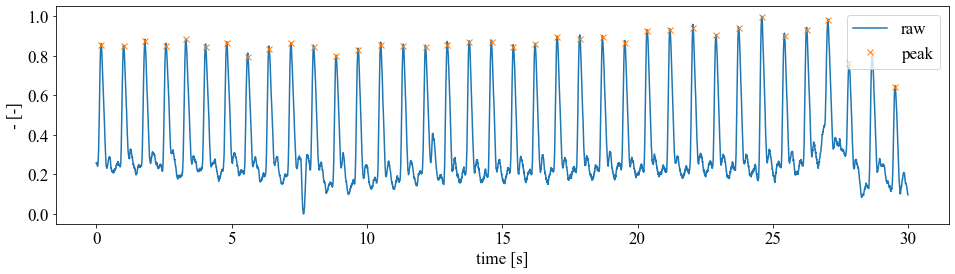

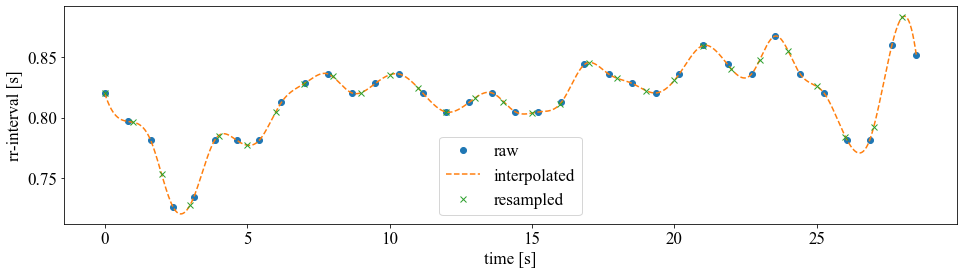

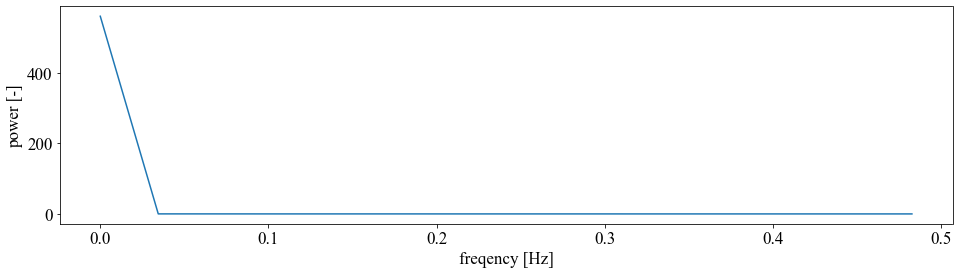

LF/HF -> 0.9331863783293066




,TIME,Sensor-G:BVP,HR (BVP)
0,00:00:00,13.687,70.000
1,00:00:00,13.991,70.000
2,00:00:00,14.671,70.000
3,00:00:00,14.423,70.000
4,00:00:00,14.317,70.000
...,...,...,...
15227,00:01:58,0.688,68.576
15228,00:01:58,0.968,68.576
15229,00:01:58,1.016,68.576
15230,00:01:58,1.315,68.576


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (35,)
rr_intervals       -> [0.8203125 0.796875  0.8203125 0.8359375 0.8203125 0.8203125 0.828125
 0.859375  0.8203125 0.796875  0.84375   0.8203125 0.859375  0.8203125
 0.8203125 0.8359375 0.84375   0.859375  0.8203125 0.84375   0.84375
 0.8515625 0.8203125 0.828125  0.8359375 0.859375  0.8203125 0.8203125
 0.84375   0.8359375 0.84375   0.8359375 0.8203125 0.859375  0.84375  ]
fixed_times shape -> (29,)
fixed_times       -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
resampled_rr_intervals shape -> (29,)
resampled_rr_intervals       -> [0.8203125  0.80021152 0.83155921 0.82556733 0.8200498  0.83140552
 0.85479801 0.7986207  0.83511931 0.82022427 0.85892835 0.81402396
 0.82996183 0.83996208 0.86046287 0.82000077 0.84636259 0.84990008
 0.82956673 0.82665021 0

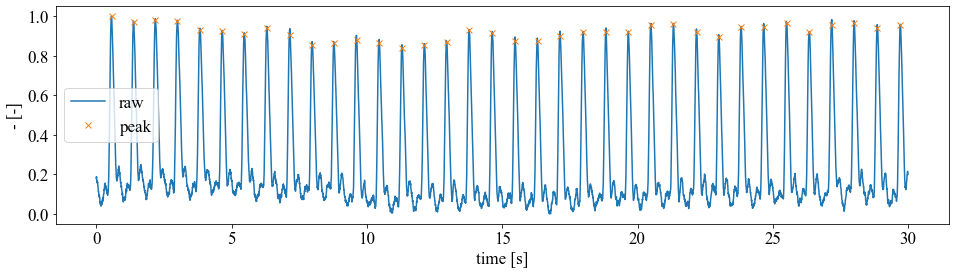

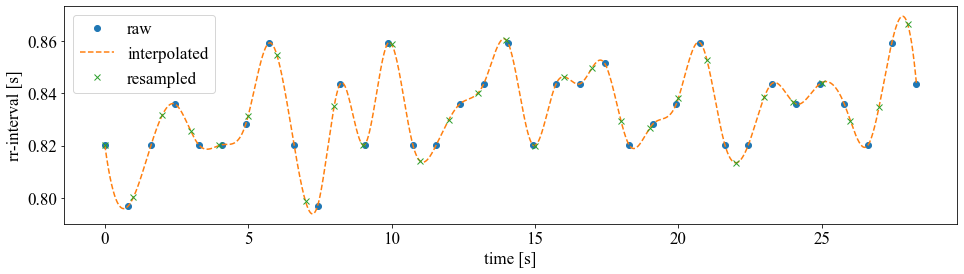

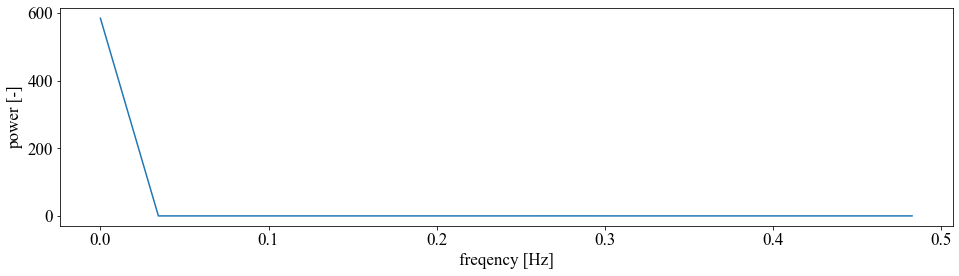

LF/HF -> 0.0867502080491485




,TIME,Sensor-G:BVP,HR (BVP)
0,00:00:00,8.216,70.00
1,00:00:00,7.409,70.00
2,00:00:00,6.449,70.00
3,00:00:00,5.451,70.00
4,00:00:00,4.674,70.00
...,...,...,...
16123,00:02:05,0.430,67.97
16124,00:02:05,-0.154,67.97
16125,00:02:05,-0.576,67.97
16126,00:02:05,-0.576,67.97


times shape -> (3840,)
times       -> [0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.99765625e+01
 2.99843750e+01 2.99921875e+01]
rr_intervals shape -> (36,)
rr_intervals       -> [0.765625  0.8046875 0.8046875 0.8359375 0.84375   0.8125    0.84375
 0.84375   0.8671875 0.84375   0.828125  0.8359375 0.8359375 0.8203125
 0.8046875 0.8125    0.828125  0.8203125 0.8125    0.8203125 0.8359375
 0.8203125 0.7734375 0.7890625 0.8125    0.8203125 0.8203125 0.8359375
 0.8125    0.8125    0.8203125 0.8203125 0.8203125 0.65625   1.015625
 0.8125   ]
fixed_times shape -> (29,)
fixed_times       -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
resampled_rr_intervals shape -> (29,)
resampled_rr_intervals       -> [0.765625   0.80435388 0.81934829 0.84779015 0.81261135 0.84591793
 0.85128512 0.85966273 0.82978439 0.83493736 0.83514008 0.81463207
 0.80589292 0.82584218 0.82079883 0.81266486 0.82758694 0.83264229
 0.77822651 0

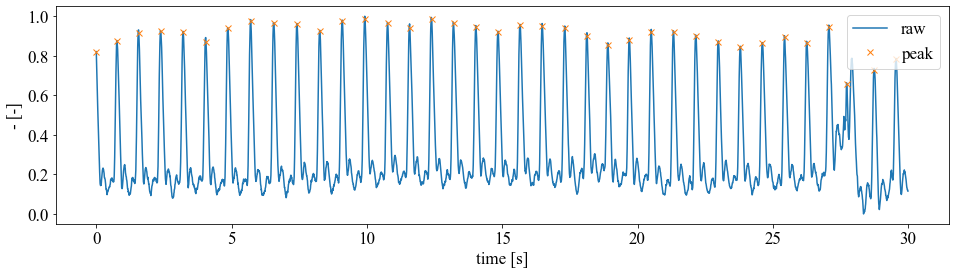

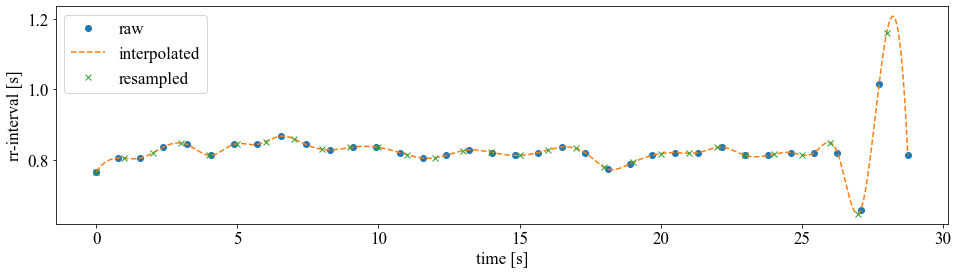

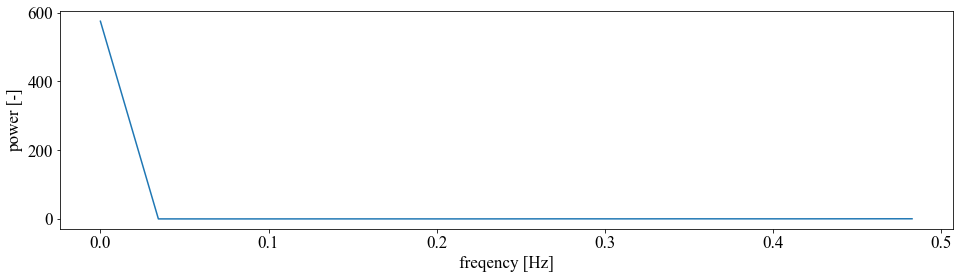

LF/HF -> 0.05070677177629942




In [336]:
ecg_analyzer = EcgAnalyzer()
data_dir = './nexus-ecg'
ecg_filepath_list = glob.glob(data_dir + '/*.txt')
for ecg_filepath in ecg_filepath_list:
    try: 
        ecg_analyzer.analyze_nexus_data(
            ecg_filepath, 
            interpolation_method='spline', 
            preceding_rest_duration=45, 
            task_duration=30, 
            following_rest_duration=45
        )
    except:
        print('error')

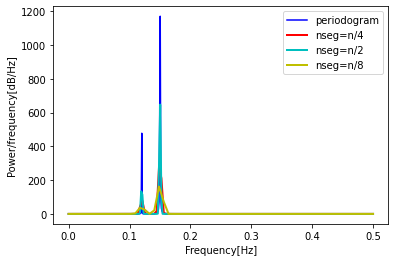

In [92]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def pgram(y):
    n = 1024
    dt = 1
    fs = 1/dt
    f1 = 120
    f2 = 150
    t = np.arange(y.shape[0])

    freq1, P1 = signal.periodogram(y, fs)
    freq2, P2 = signal.welch(y, fs)
    freq3, P3 = signal.welch(y, fs, nperseg=n/2)
    freq4, P4 = signal.welch(y, fs, nperseg=n/8)

    plt.figure()
    plt.plot(freq1, P1, "b", label="periodogram")
    plt.plot(freq2, P2, "r", linewidth=2, label="nseg=n/4")
    plt.plot(freq3, P3, "c", linewidth=2, label="nseg=n/2")
    plt.plot(freq4, P4, "y", linewidth=2, label="nseg=n/8")
    plt.legend(loc="upper right")
    plt.xlabel("Frequency[Hz]")
    plt.ylabel("Power/frequency[dB/Hz]")
    # plt.show()

t = np.linspace(1, n, n)*dt-dt
y = np.sin(2*np.pi*f1*t)+2*np.sin(2*np.pi*f2*t)+0.1*np.random.randn(t.size)
pgram(y)